## Dropout方法实现正则化

In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import torch.nn as nn

batch_size=256

d2l.use_svg_display()
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4)
next(iter(train_iter))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [2]:
## 一般实现
def dropout_layer(X,dropout):
    if dropout == 0:
        return X
    if dropout == 1:
        return torch.zeros_like(X.shape)
    mask = (torch.rand(X.shape) > dropout).float()
    return X*mask/(1-dropout)

In [3]:
dropout1, dropout2 = 0.2, 0.5
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.softmax(self.lin3(H2))
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)


In [4]:
epochs = 50
loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(),lr=0.05)

loss_table = []
test_loss_table = []
for epoch in range(epochs):
    for X,y in train_iter:
        l = loss(net(X),y)
        net.zero_grad()
        l.backward()
        optim.step()
    with torch.no_grad():
        if epoch % 5 == 0:
            print(f"epoch{epoch+1}    test_acc {d2l.evaluate_accuracy_gpu(net,iter(test_iter))}")       
        loss_table.append(loss(net(X),y).mean().detach())
        tx,ty = next(iter(test_iter))
        test_loss_table.append(loss(net(tx),ty).mean().detach())

epoch1    test_acc 0.1789
epoch6    test_acc 0.7031
epoch11    test_acc 0.7754
epoch16    test_acc 0.7899
epoch21    test_acc 0.797
epoch26    test_acc 0.8023
epoch31    test_acc 0.804
epoch36    test_acc 0.8077
epoch41    test_acc 0.8095
epoch46    test_acc 0.8111


array([<Axes: title={'center': 'ankle boot\nankle boot'}>,
       <Axes: title={'center': 'pullover\npullover'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'pullover\nshirt'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>], dtype=object)

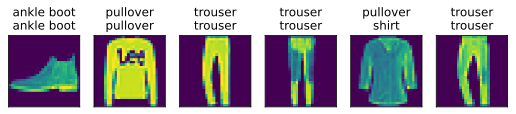

In [5]:
n = 6
X,y = next(iter(test_iter))
preds = d2l.get_fashion_mnist_labels(net(X).argmax(1))
trues = d2l.get_fashion_mnist_labels(y)
titles = [pred + "\n" + true for pred,true in zip(preds,trues)]
images = X[0:6].reshape((n,28,28))
d2l.show_images(images,1,n,titles=titles)

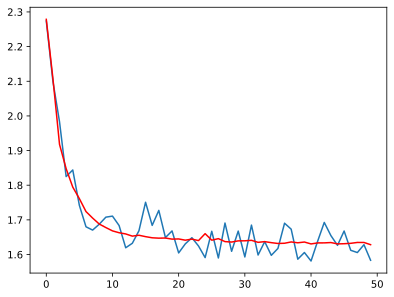

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
#loss_table = moving_average(loss_table,10)
#test_loss_table = moving_average(test_loss_table,10)
epoches = list(range(len(loss_table)))
plt.plot(epoches,loss_table)
plt.plot(epoches,test_loss_table,c='r')